# 🎦**AlloCiné Recommender System**🔎📍

Once we cleaned the data, we can start to build our recommender system. The data that will be used is located in the `../Cleaned Data/` folder.

**Types of Recommender System:**

There are two types of recommender system: **`content-based`** and **`collaborative-filtering`**.

- **`Content-based`:** this recommender system is based only on the characteristics of the products. Here, we will recommend an item to a user by comparing the features between items and recommend the items with the highest similarity. We will test two different methods:
    - Picking a random movie and recommending the ten most similar movies to it.
    - Forming a user profile vector based on the user's movie ratings and recommending the ten movies that fit best to the user's profile.
    
     

- **`Collaborative-filtering`:** this recommender system is based on the interactions between users and the items. 
    - `Memory-based`: Calculation of similarities between users or between products to recommend the right product.
        - `User-based CF`: Suggest products that have been well rated by similar users.
        - `Item-based CF`: Offer products that are well rated and similar to products already used.
    - `Model-based`: Finding a pattern explaining browsing and preferences behaviors.

By the format of our data, we will only be able to perform an `item-based CF` for the `memory-based` method as we don't have any information about the users, only their ratings and the features of the items.


---
# **Import libs**

In [17]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from PIL import Image
import glob
import re
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances, euclidean_distances
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import implicit
import surprise
from surprise import Reader, Dataset, SVD, accuracy, KNNBasic
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
import scipy.sparse as sparse
import random as rd


from ast import literal_eval
from warnings import filterwarnings
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop # Used to get the French stop-words
from IPython.display import clear_output
import traceback

# We ignore dateparse warnings
filterwarnings("ignore",message="The localize method is no longer necessary, as this time zone supports the fold attribute")
# We ignore reindexing warnings
filterwarnings("ignore",message="Boolean Series key will be reindexed")
# We ignore Future warnings
filterwarnings("ignore",message="FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version.")
%matplotlib inline

# **Load the csv files**

In [4]:
def load_csv():
    '''
    Load the csv files and return a dict of dataframes.
    '''
    root_path = f"../Cleaned Data/"
    movies = pd.read_csv(f"{root_path}movies.csv", converters={"genres": literal_eval}) # Load list look-alike string as type list
    series = pd.read_csv(f"{root_path}series.csv", converters={"genres": literal_eval})
    for c in ["actors", "directors", "nationality"]:
        movies[c] = movies[c].apply(lambda x: literal_eval(x) if type(x) == str else [])
        series[c] = series[c].apply(lambda x: literal_eval(x) if type(x) == str else [])
    press_movies = pd.read_csv(f"{root_path}press_movies.csv")
    press_series = pd.read_csv(f"{root_path}press_series.csv")
    user_movies = pd.read_csv(f"{root_path}user_movies.csv")
    user_series = pd.read_csv(f"{root_path}user_series.csv")
    #user_series = pd.read_csv(f"../Series/Ratings/Webscraping_Series_Ratings_user_ratings_series_#1-1.csv")
    return {"movies":movies, "series":series, "press_movies":press_movies, "press_series":press_series, "user_movies":user_movies, "user_series":user_series}
data = load_csv()
movies, series, press_movies, press_series, user_movies, user_series = data["movies"], data["series"], data["press_movies"], data["press_series"], data["user_movies"], data["user_series"]

---
# **Content-based (CB)**

## **Functions:**

### Get stop-words: `get_stop_words()`

In [5]:
def get_stop_words():
    '''
    Get the French and English stop-words for tagging.
    :return: list of French and Enlish stop-words.
    '''
    # turn French stop-words into a list
    stop_words = list(fr_stop)
    # Load extra stop-words in French and in English
    with open("stop_words_french.txt",'r', encoding='UTF-8') as file:
        additional_stopwords = file.readlines()
        additional_stopwords = [line.rstrip() for line in additional_stopwords]
    with open("stop_words_eng.txt",'r', encoding='UTF-8') as file:
        additional_stopwords_eng = file.readlines()
        additional_stopwords_eng = [line.rstrip() for line in additional_stopwords_eng]
    
    # Add the additional French stop-words to the list of stop-words if they are not already in it
    for word, word_eng in zip(additional_stopwords,additional_stopwords_eng):
        if word not in stop_words:
            stop_words.append(word)
        if word_eng not in stop_words:
            stop_words.append(word_eng)
    stop_words.extend([""," ","#","-",":","(",")"])
    return stop_words

### Get tags: `get_tags(df, stop_words, cols_to_get)`

In [6]:
def get_tags(df: pd.DataFrame=None, stop_words: list=get_stop_words(), cols_to_get: str="title"):
    '''
    Get the tags of the movies from the title and/or summary.
    :param df: Dataframe to transform.
    :param stop_words: List of stop-words to remove from the tags.
    :param col_to_get: Columns to get the tags from.
    '''
    try:
        # We remove unecessary punctuation and characters from the title 
        # And store the title's keywords in a list
        rmv_char = r"(!|#|:|\$|\%|\^|\&|\*|\(|\)|-|\+|/|\?|\.+|\d)"
        df["tags"] = df[cols_to_get].apply(lambda x: re.split(" |,|\. |\.\.\.|\"|'|-", re.sub(rmv_char, " ", x)))
        df["tags"] = df["tags"].apply(lambda x: [i for i in x if i.lower() not in stop_words])
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()
    return df

### Get dummies df: `get_dummies_df(df, keep_cols, cols_to_dummies)`

In [7]:
def get_dummies_df(df_key: str="movies", keep_cols: list=None, cols_to_dummies: list=["genres"]):
    '''
    Get a dataframe with the dummies of the column cols_to_dummies.
    :param df_key: Key of the dataframe from dict 'data' to transform.
    :param keep_cols: List of columns to keep.
    :param cols_to_dummies: List of columns to transform to dummies.
    :return: Original dataframe with the concatenated dummies datframe of the columns cols_to_dummies.
    '''
    try:
        df_dummies = data[df_key][keep_cols]
        # We drop the movies with no user rating
        df_dummies = df_dummies.dropna(subset=["user_rating"], axis=0)
        df_dummies = df_dummies.reset_index(drop=True)
        # We keep only the release year as a recommendation feature
        df_dummies["release_date"] = df_dummies["release_date"].apply(lambda x: int(x.split("-")[0]))
        
        # We add the tag column to the dataframe
        if "tags" in cols_to_dummies:
            df_dummies = get_tags(df=df_dummies) 

        non_dummy_cols = df_dummies.shape[1]

        # We create binary variables for each cols_to_dummies feature by One-Hot encoding their values
        for col in cols_to_dummies:  
            encode_col = pd.get_dummies(df_dummies[col].apply(pd.Series).stack()).groupby(level=0).sum()
            df_dummies = pd.concat([df_dummies, encode_col], axis=1)
        
        # We sort the movies by title and release date
        df_dummies.sort_values(by=["title", "release_date"], ascending=[True,False]).reset_index(drop=True, inplace=True)                   
        
        # We replace NaN values in the dummy columns with 0
        df_dummies.iloc[:,non_dummy_cols:] = df_dummies.iloc[:,non_dummy_cols:].fillna(0)
        # We add +1 to the people who are both actors and directors for the same movie
        duplicated_cols = df_dummies.columns[df_dummies.columns.duplicated()]
        for col in duplicated_cols:
            df_dummies[col] = df_dummies[col].sum(axis=1)
        # We remove duplicated dummies columns (from people who are both actors and directors)
        df_dummies = df_dummies.loc[:,~df_dummies.columns.duplicated()].copy()
               
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()   
        return None
    return df_dummies

### Normalize: `normalize(matrix, dummies_df, binary, multiply_by_ratings, scaler, vectorize)`

In [8]:
def normalize_matrix(matrix: pd.DataFrame, dummies_df: pd.DataFrame=None, numerical_cols: list=[], cols_to_scale: list=[], binary: bool=False, multiply_by_ratings: bool=False, scaler: str="None", vectorize: bool=False):
    '''
    Normalize the matrix.
    :param matrix: Matrix to normalize.
    :param dummies_df: Dummies dataframe with ratings.
    :param numerical_cols: List of extra numerical columns we added to the dummies df.
    :param cols_to_scale: List of the numerical columns to scale.
    :param binary: If True, we normalize the matrix by dividing the term occurrence (1/0) by the number of features in the movie.
    :param multiply_by_ratings: If True, we multiply the matrix by the ratings of the movies.
    :param scaler: Method to use for normalization.
    :param vectorize: If True, we vectorize the matrix.
    :return: Normalized matrix or normalized user vector.
    '''
    try:
        scaled_matrix = matrix.copy()
        if binary: # Normalize the matrix by dividing the term occurrence (1/0) by the number of features in the movie.
            scaled_matrix.iloc[:,len(numerical_cols):] = scaled_matrix.iloc[:,len(numerical_cols):] / scaled_matrix.iloc[:,len(numerical_cols):].sum(axis=1).values[:,None]
        if multiply_by_ratings: # Weigh the features by the ratings of the movies.
            scaled_matrix.iloc[:,len(numerical_cols):] = scaled_matrix.iloc[:,len(numerical_cols):] * dummies_df["user_rating"].values[:,None]
        if vectorize: # We vectorize the matrix.
            user_vector = scaled_matrix.sum().values.reshape(1,-1)
            if scaler == "l1":
                user_vector = normalize(user_vector, axis=1, norm='l1')
            elif scaler == "l2":
                user_vector = normalize(user_vector, axis=1, norm='l2')           
            elif scaler == "min-max" or scaler == "max":
                user_vector = normalize(user_vector, axis=1, norm='max')
            return user_vector
        # If the matrix is not vectorized, we normalize the matrix.
        if scaler == "standard": # Apply standard normalization on the matrix and the cols_to_scale columns.         
            scaled_matrix.iloc[:,len(numerical_cols):] = (scaled_matrix.iloc[:,len(numerical_cols):] - scaled_matrix.iloc[:,len(numerical_cols):].mean(axis=0)) / scaled_matrix.iloc[:,len(numerical_cols):].std(axis=0)
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = (scaled_matrix[cols_to_scale] - scaled_matrix[cols_to_scale].mean(axis=0)) / scaled_matrix[cols_to_scale].std(axis=0)
        if scaler == "l1": # Apply l1 normalization on the matrix and the cols_to_scale columns.
            scaled_matrix.iloc[:,len(numerical_cols):] = normalize(scaled_matrix.iloc[:,len(numerical_cols):], axis=1, norm='l1')
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = normalize(scaled_matrix[cols_to_scale], axis=1, norm='l1')
        if scaler == "l2": # Apply l2 normalization on the matrix and the cols_to_scale columns.
            scaled_matrix.iloc[:,len(numerical_cols):] = normalize(scaled_matrix.iloc[:,len(numerical_cols):], axis=1, norm='l2')
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = normalize(scaled_matrix[cols_to_scale], axis=1, norm='l2')
        if scaler == "max":# Apply Max normalization on the matrix and the cols_to_scale columns.
            scaled_matrix.iloc[:,len(numerical_cols):] = normalize(scaled_matrix.iloc[:,len(numerical_cols):], axis=1, norm='max')
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = normalize(scaled_matrix[cols_to_scale], axis=1, norm='max')
        elif scaler == "min-max": # Apply min-max normalization on the matrix and the cols_to_scale columns.
            scaled_matrix.iloc[:,len(numerical_cols):] = (scaled_matrix.iloc[:,len(numerical_cols):] - scaled_matrix.iloc[:,len(numerical_cols):].min(axis=0)) / (scaled_matrix.iloc[:,len(numerical_cols):].max(axis=0) - scaled_matrix.iloc[:,len(numerical_cols):].min(axis=0))
            if cols_to_scale:
                scaled_matrix[cols_to_scale] = (scaled_matrix[cols_to_scale] - scaled_matrix[cols_to_scale].min(axis=0)) / (scaled_matrix[cols_to_scale].max(axis=0) - scaled_matrix[cols_to_scale].min(axis=0))
       
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()
        return None
    return scaled_matrix

### Compute Similarity: `compute_similarity(feature_df, user_vector, similarity_metric)`

In [9]:
def compute_similarity(feature_df: pd.DataFrame=None, user_vector: np.array=None, similarity_metric: str="cosine"):
    '''
    Compute the similarity between the movies/series vectors.
    :param feature_df: Dataframe with the movies/series features to compute the similarity.
    :param user_vector: User vector to compute the similarity with the movies/series vectors.
    :param similarity_metric: Similarity metric to use (cosine|euclidean).
    :return: Similarity matrix between the movies/series vectors.
    '''
    try:
        # We compute the similarity between the user vector and the movies/series vectors if user_vector is not None.
        if user_vector is not None:
            if similarity_metric == "cosine":
                return cosine_similarity(user_vector, feature_df)
            if similarity_metric == "euclidean":
                return euclidean_distances(user_vector, feature_df)      
            else:
                print(f"Error: {similarity_metric} is not a valid similarity metric.")        
        # We compute the similarity matrix between the movies/series vectors
        else:
            if similarity_metric == "cosine":
                return cosine_similarity(feature_df)
            if similarity_metric == "euclidean":
                return euclidean_distances(feature_df)        
            else:
                print(f"Error: {similarity_metric} is not a valid similarity metric.")    
    except Exception as e:
        print(f"Error: {e}")
        traceback.print_exc()
        return None       

### Display recommendations: `display_recos(v_titles, v_ids, v_type, reco_type)`

In [10]:
def display_recos(v_titles: tuple, v_ids: tuple, v_type: str="movies", reco_type: str="item-item"):
    '''
    Display the recommendations for a movie/series.
    :param v_titles: Tuple of the requested movie's/series' title (or the requested user's name) and the a list of tuples of the recommended movies'/series' titles and the score/rating associated with it.
    (e.g. ("The Matrix", [("The Matrix", 0.9), ("The Matrix Reloaded", 0.8), ("The Matrix Revolutions", 0.7), ...]).
    :param v_ids: Tuple of the requested movie's/series' id (or None) and the a list of tuples of the recommended movies'/series' ids. (e.g. (123, [654, 8789, 256, ...]).
    :param v_type: 'movies' or 'series'. Default is 'movies'.
    :param reco_type: 'item-item', 'user-item' or 'user-profile'.
    :return: None, just display the recommendations.
    '''
    try:
        if reco_type == "item-item":
            #**************************************
            # We display the requested movie
            #**************************************
            f1 = plt.figure(figsize=(8,8))
            f1.suptitle("The movie you requested is:\n", fontsize=20, fontweight='bold')
            title = v_titles[0]
            split_title = title.split(" ")
            len_title = len(title)
            # We adapt the title display to the plot size depending on its length.
            title = title if len_title <= 36 else " ".join(split_title[:len(split_title)//2]) + "\n" + " ".join(split_title[len(split_title)//2:])
            plt.title(title.title(), fontsize=15, fontweight='bold')
            plt.axis('off') # We don't want to display the axis.
            plt.imshow(Image.open(glob.glob(f"../{v_type.title()}/Posters/*_{v_ids[0]}.jpg")[0]))

        #**************************************
        # We display the recommendations
        #**************************************    
        n = len(v_titles[1])
        f2 = plt.figure(figsize=(20,6*n//5))
        if reco_type == "item-item":
            f2.suptitle(f"If you like this movie, you might also like:", fontsize=20, fontweight='bold')
        elif reco_type == "user-item":
            f2.suptitle(f"Here are {n} {v_type} recommendations for user '{v_titles[0]}'", fontsize=20, fontweight='bold')
        elif reco_type == "user_profile":
            f2.suptitle(f"Here is the Top {n} {v_type} of user '{v_titles[0]}'", fontsize=20, fontweight='bold')
        for i in range(n):
            f2.add_subplot(n//5,5,i+1)
            title = v_titles[1][i][0]
            split_title = title.split(" ")
            len_title = len(title)
            # We adapt the title display to the plot size depending on its length.
            title = title if len_title <= 21 else " ".join(split_title[:len(split_title)//2]) + "\n" + " ".join(split_title[len(split_title)//2:])
            plt.title(title.title(),fontweight='bold')
            plt.axis('off') # We don't want to display the axis.
            if reco_type == "item-item":
                plt.text(0, 470, f"Similarity:\n{v_titles[1][i][1]}")
            elif reco_type == "user-item":
                plt.text(0, 470, f"Rating prediction:\n{v_titles[1][i][1]}")
            elif reco_type == "user_profile":
                plt.text(0, 470, f"User rating:\n{v_titles[1][i][1]}")
            plt.imshow(Image.open(glob.glob(f"../{v_type.title()}/Posters/*_{v_ids[1][i]}.jpg")[0]))

        plt.show(block=True)
    except Exception as e:
        print(e)
        traceback.print_exc()

### Display Top favourite movies: `display_top_movies(user_id, user_movies_df, movies, top_movies)`

In [11]:
def display_top_movies(user_id: str="", user_movies_df: pd.DataFrame=user_movies, movies: pd.DataFrame=movies, top_movies: int=5):
    '''
    Display the top top_movies movies of a user.
    :param user_id: user ID.
    :param user_movies_df: DataFrame of user ratings.
    :param movies: DataFrame of movies.
    :param top_movies: number of top movies to display.
    :return: None.
    '''
    # Get all movies ID from user ID and their ratings
    user_movie_list = user_movies_df[user_movies_df.user_id == user_id][["user_name","movie_id","user_rating"]]
    user_name = user_movie_list.user_name.values[0]
    # Get all movies rated by the user
    user_profile = movies.loc[movies["id"].isin(user_movie_list.movie_id.to_list())]    
    user_profile = user_profile.assign(user_rating=user_movie_list.user_rating.to_list())    

    #*********************************************
    # Display the favourite movies of the user
    #*********************************************
    user_profile.sort_values(by="user_rating", ascending=False, inplace=True)
    # The number of movies displayed is the minimum between the number of movies rated by the user and the top_movies parameter.
    top_movies = min(top_movies, len(user_profile))
    user_movies_titles = [(user_profile.title.values[j], user_profile.user_rating.values[j]) for j in range(top_movies)]
    display_recos((user_name, user_movies_titles), 
                  (None, user_profile.id.values[:top_movies]), 
                  v_type="movies", reco_type="user_profile")

### Get CB recommendations: `CB_recommendations(title, sim_matrix, nb_recos, dummies_df)`

In [12]:
def CB_recommender(title: str="The Batman", sim_matrix: np.array=None, nb_recos: int=10, dummies_df: pd.DataFrame=None, drop_movie: bool=True):
    '''
    Get the recommendations for a movie.
    :param title: Title of the movie to get the recommendations for.
    :param sim_matrix: Similarity matrix.
    :param nb_recos: Number of recommendations to get.
    :param dummies_df: Dataframe with the dummified features of the movies.
    :param drop_movie: Drop the requested movie from the recommendations.
    :return: Tuples of the recommended movies' titles, with similarity value and IDs.      
    '''
    CB_recos = [] # Initialization of the list of recommendations
    title_keywords = title.split(" ") # We split the title into keywords
    title_list = [] # Initialization of the list of titles
    movies_ids_list = [] # Initialization of the list of movie IDs
    # We collect all the movies titles (with their respective id) which contain all the keywords of the title variable
    for full_title, id in zip(dummies_df.title.values.tolist(), dummies_df.id.values.tolist()):
        if all(word.lower() in full_title.lower() for word in title_keywords):
            title_list.append((full_title,id))
    
    clear_output(wait=True)
    # If we get a direct match, we return the title.    
    if len(title_list) == 1:
        current_title = title_list[0]
    # Else, we get all the movies with similar names and ask the user to choose one.
    elif len(title_list) > 1:
        print(f"Several movies ({len(title_list)}) found with similar titles. Please choose one of the following:")
        for i, item in enumerate(title_list,1):
            print(i, f': {item}', sep='',end='\n')
        choice = -1
        while choice < 1 or choice > len(title_list):
            choice = int(input("Enter the number of the movie: "))
        current_title = title_list[choice-1]
    else:
        return f'Error: The movie {title} requested was not found.'

    clear_output(wait=True)
    # If the movie is in the database
    idx = dummies_df.index[dummies_df.id == current_title[1]][0] # We retrieve the index of the movie by its id
    # We sort the similarity matrix of the movies and we drop the movie itself
    score_series = pd.Series(sim_matrix[idx]).drop(idx).sort_values(ascending=False) if drop_movie else pd.Series(sim_matrix[idx]).sort_values(ascending=False) 
    top_nbrecos = list(score_series.iloc[0:nb_recos].index) # We select the top nb_recos movies 
    # We store the titles of the top nb_recos movies in the list CB_recos and return it
    for i in top_nbrecos:             
        CB_recos.append((dummies_df.title[i], sim_matrix[idx][i]))
        movies_ids_list.append(dummies_df.id[i])
    
    return (current_title[0],CB_recos), (current_title[1],movies_ids_list)

### Get CB user recommendations: `CB_user_recommendations(user_movies, dummies_df, feature_matrix, norm_feature_matrix, norm_scaler, index, display_top_features, drop_viewed_movies, top_movies, nb_recos)`

In [13]:
def CB_user_recommendations(user_movies_df: pd.DataFrame, dummies_df: pd.DataFrame=None, feature_matrix: pd.DataFrame=None, norm_feature_matrix: pd.DataFrame=None, norm_scaler: str="l2", index: int=-1, display_top_features: bool=True, drop_viewed_movies: bool=True, top_movies: int=5, nb_recos: int=10):
    '''
    Get the recommendations for a user.
    :param user_movies_df: Dataframe of the user movie ratings with user and movie IDs.
    :param dummies_df: Dataframe with the dummies and average ratings of the movies.
    :param feature_matrix: Feature matrix of all the movies.
    :param norm_feature_matrix: Normalized feature matrix of all the movies.
    :param norm_scaler: Normalization scaler for the user profile vector.
    :param index: Index of the user in the list of user_ids sorted by the descending number of reviews. If -1, the user is chosen by the user.
    :param display_top_features: Display the top features of the user profile.
    :param drop_viewed_movies: Boolean to drop the movies already watched by the user from the recommendations.
    :param top_movies: Top top_movies favourite movies from the user's profile.
    :param nb_recos: Number of recommendations to get.
    :return: Tuples of the recommended movies' titles, with similarity value and IDs.   
    '''    
    CB_recos = [] # Initialization of the list of recommendations
    movies_ids_list = [] # Initialization of the list of movie IDs

    # In the user_movies df, remove users who appears less than 5 times (-> have made less than 5 reviews)
    user_movies = user_movies_df.groupby('user_id').filter(lambda x: len(x) >= 5)    
    # Get all unique user ids sorted by the descending number of reviews
    user_ids = user_movies.user_id.value_counts().index

    # Ask the user to choose a user    
    while index < 0 or index >= len(user_ids):
        index = int(input(f"Enter the number of the user you want to get recommendations for (between 1 and {len(user_ids)}): ")) - 1 
    # Get all movies ID from user ID and their ratings
    user_id = user_ids[index]
    user_movie_list = user_movies[user_movies.user_id == user_id][["user_name","movie_id", "user_rating"]]
    user_name = user_movie_list.user_name.values[0]
    # Get all movies rated by the user
    user_profile = dummies_df.loc[dummies_df["id"].isin(user_movie_list.movie_id.to_list())]    
    user_profile = user_profile.assign(user_rating=user_movie_list.user_rating.to_list())
    # We retrieve the feature matrix of the user profile
    features_user_matrix = feature_matrix.loc[user_profile.index]
    # We create and normalize the user profile
    norm_user_profile = normalize_matrix(features_user_matrix, dummies_df=user_profile, binary=False, multiply_by_ratings=True, scaler=norm_scaler, vectorize=True)

    #***************************************************************
    # We plot the most important features of the user profile
    #***************************************************************
    if display_top_features:
        nup = pd.DataFrame(norm_user_profile[0], index=features_user_matrix.columns, columns=["norm_value"])
        nup.sort_values(by="norm_value", ascending=False, inplace=True)
        nup = nup[nup.norm_value != 0].iloc[:30]
        plt.figure(figsize=(19, 8))
        plt.title(f"Normalized User Profile for user \"{user_movie_list.user_name.values[0]}\"", fontsize=20, fontweight="bold")
        ax = sns.barplot(x=nup.index, y=nup.norm_value)
        ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
        plt.show()

    #*********************************************
    # Display the favourite movies of the user
    #*********************************************
    if top_movies >= 0:
        display_top_movies(user_id, user_movies_df, movies, top_movies)

    # We compute the similarity between the user profile and the feature matrix
    sim_matrix = compute_similarity(norm_feature_matrix, norm_user_profile, similarity_metric="cosine")
    # We sort the similarity matrix of the movies and we drop (or not) the movies already watched by the user.
    score_series = pd.Series(sim_matrix[0]).drop(user_profile.index).sort_values(ascending=False) if drop_viewed_movies else pd.Series(sim_matrix[0]).sort_values(ascending=False)
    top_nbrecos = list(score_series.iloc[0:nb_recos].index) # We select the top nb_recos movies 
    # We store the titles of the top nb_recos movies in the list CB_recos and return it
    for i in top_nbrecos:             
        CB_recos.append((dummies_df.title[i], sim_matrix[0][i]))
        movies_ids_list.append(dummies_df.id[i])
    
    return (user_name,CB_recos), (None, movies_ids_list)

### Intra-List Similarity (ILS): `ILS(movies, norm_feature_matrix, m_ids)`

In [14]:
def ILS(movies: pd.DataFrame, norm_features_matrix: pd.DataFrame, m_titles: list, m_ids: list):
    """
    Compute the Intra-List Similarity (ILS) of the recommendations the user has had.
    :param movies: The movies dataframe.
    :param norm_features_matrix: The normalized features matrix.
    :param m_ids: The list of movie ids recommended to the user.
    :return: The ILS of the user.
    """
    ils = 0
    for i in range(len(m_ids)):
        m_i = norm_features_matrix.iloc[movies[movies.id == m_ids[i]].index]
        for j in range(i+1, len(m_ids)):
            m_j = norm_features_matrix.iloc[movies[movies.id == m_ids[j]].index]
            ils += cosine_similarity(m_i, m_j)[0][0]            
    return ils

## **Model CB N°1:** Genres with rating ponderation

In [ ]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep = ["id", "title", "release_date", "user_rating", "genres"]
v_type = "movies"

In [ ]:
movies_dummies = get_dummies_df(df_key=v_type, keep_cols=cols_to_keep, cols_to_dummies=["genres"])

In [ ]:
features_matrix = movies_dummies.iloc[:,len(cols_to_keep):]
norm_features_matrix = normalize_matrix(features_matrix, dummies_df=movies_dummies, binary=True, multiply_by_ratings=False, scaler="None")

In [ ]:
# We compute the cosine similarity between each movie
sim_matrix = compute_similarity(norm_features_matrix, "cosine") 

In [ ]:
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix, nb_recos=10, dummies_df=movies_dummies)
display_recos(m_titles, m_ids, v_type=v_type)

The similarity between movies is very high, so a lot of movies with the highest similarity are recommended to the user. But depending on the original order of the movies, the order of the recommendations may change and therefore may not be very relevant. This is because we only considered the genres as a comparison criterion. We need to use more features or add a ponderation if we want to have a more accurate recommendation. 

So far, I obtained better recommendation by multiplying the correlation matrix by the movies' ratings. After reflexion, it appeared more sensible to multiply the encoded feature matrix by the ratings before computing the siùilarity. In that way, movies with the same genres will more likely be similar if they have a high rating.

## **Model CB N°2:** Model 1 + tag analysis

In [ ]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep_2 = ["id", "title", "release_date", "user_rating", "genres", "summary"]
v_type = "movies"

In [ ]:
movies_dummies_2 = get_dummies_df(df_key=v_type, keep_cols=cols_to_keep_2, cols_to_dummies=["genres", "tags"])

In [ ]:
features_matrix_2 = movies_dummies_2.iloc[:,len(cols_to_keep_2)+1:]
norm_features_matrix_2 = normalize_matrix(features_matrix_2, dummies_df=movies_dummies_2, binary=True, multiply_by_ratings=False, scaler="None")

In [ ]:
# We compute the cosine similarity between each movie and multiply it by the user rating.
sim_matrix_2 = compute_similarity(norm_features_matrix_2, "cosine")

In [ ]:
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix_2, nb_recos=10, dummies_df=movies_dummies_2)
display_recos(m_titles, m_ids, v_type=v_type)

In this second model, we used the titles of the movies to help recommend movies that, at first sight, may seem to talk about the same subject. What we notice from this new model is that movies with that share parts of their title are more likely to be recommended to the user, even though they have a lower rating. Moreover, as we decided to remove all punctuation marks and symbols characters, movies like `"X-Men"` will become `"X Men"`, and as both words are considered as stop-words, they will never be used to suggests on purpose other movies from the `"X-Men Saga"`. Movies with titles like `"Le Monde de Narnia : Chapitre 1 - Le lion, la sorcière blanche et l'armoire magique"` won't be affected by this characters removal.

## **Model CB N°3:** Model 1 + actors + directors + nationality

In [15]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep_3 = ["id", "title", "release_date", "duration", "user_rating", "genres", "actors", "directors", "nationality"]
v_type = "movies"

In [ ]:
movies_dummies_3 = get_dummies_df(df_key=v_type, keep_cols=cols_to_keep_3, cols_to_dummies=["genres", "actors", "directors", "nationality",])

In [ ]:
numerical_cols = ["release_date", "duration"]
features_matrix_3 = movies_dummies_3[numerical_cols + movies_dummies_3.iloc[:,len(cols_to_keep_3):].columns.to_list()]
norm_features_matrix_3_minmax = normalize_matrix(features_matrix_3, dummies_df=movies_dummies_3, numerical_cols=numerical_cols, 
                                    cols_to_scale=["release_date", "duration"] , binary=False, multiply_by_ratings=True, scaler="min-max")
norm_features_matrix_3_l1 = normalize_matrix(features_matrix_3, dummies_df=movies_dummies_3, numerical_cols=numerical_cols, 
                                    cols_to_scale=["release_date", "duration"] , binary=False, multiply_by_ratings=True, scaler="l1")
norm_features_matrix_3_l2 = normalize_matrix(features_matrix_3, dummies_df=movies_dummies_3, numerical_cols=numerical_cols, 
                                    cols_to_scale=["release_date", "duration"] , binary=False, multiply_by_ratings=True, scaler="l2")
norm_features_matrix_3_max = normalize_matrix(features_matrix_3, dummies_df=movies_dummies_3, numerical_cols=numerical_cols, 
                                    cols_to_scale=["release_date", "duration"] , binary=False, multiply_by_ratings=True, scaler="max")

In [ ]:
# We compute the cosine similarity between each movie and multiply it by the user rating.
sim_matrix_3_minmax = compute_similarity(norm_features_matrix_3_minmax, similarity_metric="cosine")
sim_matrix_3_l1 = compute_similarity(norm_features_matrix_3_l1, similarity_metric="cosine")
sim_matrix_3_l2 = compute_similarity(norm_features_matrix_3_l2, similarity_metric="cosine")
sim_matrix_3_max = compute_similarity(norm_features_matrix_3_max, similarity_metric="cosine")

In [ ]:
# MODEL CB N°3 MIN-MAX #3 (Accurate recos, lowest similarity)
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix_3_minmax, nb_recos=20, dummies_df=movies_dummies_3, drop_movie=True)
display_recos(m_titles, m_ids, v_type=v_type)

In [ ]:
# MODEL CB N°3 MAX (V2) #2 (Accurate recos, lowest similarity)
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix_3_max, nb_recos=20, dummies_df=movies_dummies_3, drop_movie=True)
display_recos(m_titles, m_ids, v_type=v_type)

In [ ]:
# MODEL CB N°3 L1 #4 (not perfect recos, highest similarity)
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix_3_l1, nb_recos=20, dummies_df=movies_dummies_3, drop_movie=True)
display_recos(m_titles, m_ids, v_type=v_type)

In [ ]:
# MODEL CB N°3 L2 (BEST) #1 (accurate recos but more diversity, intermediate similarity)
m_titles, m_ids = CB_recommender(title=input("Enter a movie title or keywords: "), sim_matrix=sim_matrix_3_l2, nb_recos=20, dummies_df=movies_dummies_3, drop_movie=True)
display_recos(m_titles, m_ids, v_type=v_type)

The difference between those 4 models is based on the normalization method wich will affect the similarity score as well as the relevancy and order of the recommendations. When using  l1-normalization, we obtain the highest accuracy score on all recommended items, but we also get the least relevant recommendations. With min-max normalization, we obtain a pretty accurate recommendation but the similarity is lower than the other 3 normalization methods. With Max normalization, we obtain a relevant recommendation overall, with a good similarity. Finally, with l2-normalization, we obtain relevant and interesting recommendations allowing more diversity based on some features, with an high intermediate similarity.

## **Model CB N°4:** Recommend movies from user profile

In [ ]:
# We retrieve only the useful columns for the content-based recommender system
cols_to_keep_4 = ["id", "title", "release_date", "duration", "user_rating", "genres", "actors", "directors", "nationality"]
v_type = "movies"

In [ ]:
movies_dummies_4 = get_dummies_df(df_key=v_type, keep_cols=cols_to_keep_4, cols_to_dummies=["genres", "actors", "directors", "nationality"])

In [ ]:
numerical_cols = []
# We retrieve the features matrix of the movies
features_matrix_4 = movies_dummies_4[numerical_cols + movies_dummies_4.iloc[:,len(cols_to_keep_4):].columns.to_list()]
# We normalize the features matrix
norm_features_matrix_4 = normalize_matrix(features_matrix_4, dummies_df=movies_dummies_4, numerical_cols=numerical_cols, 
                                    cols_to_scale=[] , binary=False, multiply_by_ratings=True, scaler="l2")
norm_features_matrix_4_max = normalize_matrix(features_matrix_4, dummies_df=movies_dummies_4, numerical_cols=numerical_cols, 
                                    cols_to_scale=[] , binary=False, multiply_by_ratings=True, scaler="max")
norm_features_matrix_4_minmax = normalize_matrix(features_matrix_4, dummies_df=movies_dummies_4, numerical_cols=numerical_cols, 
                                    cols_to_scale=[] , binary=False, multiply_by_ratings=True, scaler="min-max")


In [ ]:
# User-based CB recos - L2
m_titles, m_ids = CB_user_recommendations(user_movies_df=user_movies, dummies_df=movies_dummies_4, feature_matrix=features_matrix_4, norm_feature_matrix=norm_features_matrix_4, norm_scaler="l2",
                                          drop_viewed_movies=False, top_movies=15, nb_recos=15)
display_recos(m_titles, m_ids, v_type=v_type, reco_type="user-item")

In [ ]:
# User-based CB recos - min-max
m_titles, m_ids = CB_user_recommendations(user_movies_df=user_movies, dummies_df=movies_dummies_4, feature_matrix=features_matrix_4, norm_feature_matrix=norm_features_matrix_4_minmax, norm_scaler="min-max", drop_viewed_movies=False, top_movies=15, nb_recos=15)
display_recos(m_titles, m_ids, v_type=v_type, reco_type="user-item")

In [ ]:
# User-based CB recos - max
m_titles, m_ids = CB_user_recommendations(user_movies_df=user_movies, dummies_df=movies_dummies_4, feature_matrix=features_matrix_4, norm_feature_matrix=norm_features_matrix_4_max, norm_scaler="max", drop_viewed_movies=False, top_movies=15, nb_recos=15)
display_recos(m_titles, m_ids, v_type=v_type, reco_type="user-item")

### ILS

In [ ]:
ils_L2 = 0
nb_user = 200 
for i in tqdm(range(nb_user), desc="ILS L2"):
    m_titles, m_ids = CB_user_recommendations(user_movies_df=user_movies, dummies_df=movies_dummies_4, feature_matrix=features_matrix_4, norm_feature_matrix=norm_features_matrix_4, norm_scaler="l2",
                                          index=i, display_top_features=False, drop_viewed_movies=True, top_movies=-1, nb_recos=100)
    ils_L2 += ILS(movies_dummies_4, norm_features_matrix_4, m_titles, m_ids[1])
print("ILS L2: ", ils_L2/nb_user)

In [ ]:
ils_minmax = 0
nb_user = 200
for i in tqdm(range(nb_user), desc="ILS Min-Max"):
    m_titles, m_ids = CB_user_recommendations(user_movies_df=user_movies, dummies_df=movies_dummies_4, feature_matrix=features_matrix_4, norm_feature_matrix=norm_features_matrix_4_minmax, norm_scaler="min-max", index=i, display_top_features=False, drop_viewed_movies=True, top_movies=-1, nb_recos=100)
    ils_minmax += ILS(movies_dummies_4, norm_features_matrix_4_minmax, m_titles, m_ids[1])
print("ILS min-max: ", ils_minmax/nb_user)

In [ ]:
ils_max = 0
nb_user = 200
for i in tqdm(range(nb_user), desc="ILS Max"):
    m_titles, m_ids = CB_user_recommendations(user_movies_df=user_movies, dummies_df=movies_dummies_4, feature_matrix=features_matrix_4, norm_feature_matrix=norm_features_matrix_4_max, norm_scaler="max", index=i, display_top_features=False, drop_viewed_movies=True, top_movies=-1, nb_recos=100)
    ils_max += ILS(movies_dummies_4, norm_features_matrix_4_max, m_titles, m_ids[1])
print("ILS max: ", ils_max/nb_user)

---
# **Collaborative-Filtering (CF)**

## **Plots**

In [14]:
# Sparsity
n_interactions = user_movies.shape[0]
n_users = user_movies.user_id.nunique()
n_items = user_movies.movie_id.nunique()
print(f"Number of users: {n_users}")
print(f"Number of movies: {n_items}")
print(f"Number of interactions: {n_interactions}")
print(f"Sparsity: {n_interactions / (n_users * n_items):.2%}")

Number of users: 20220
Number of movies: 7806
Number of interactions: 325189
Sparsity: 0.21%


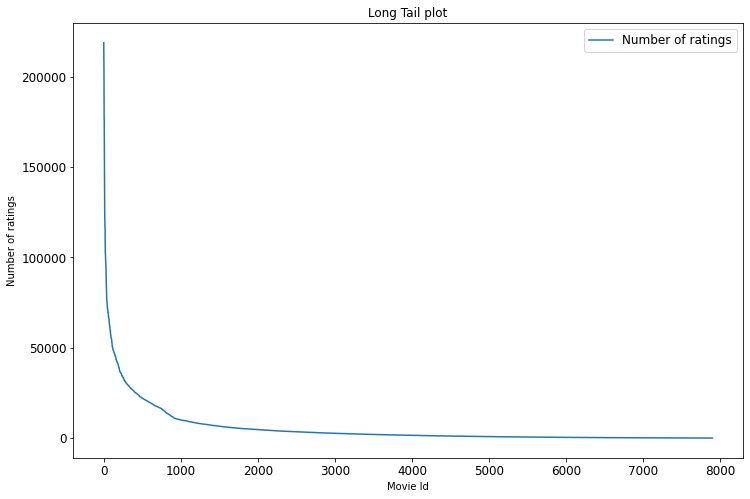

In [15]:
# plot long tail
ax = movies[["nb_user_rating"]].sort_values('nb_user_rating',ascending=False).reset_index(drop=True).plot(figsize=(12, 8), title='Long Tail plot', fontsize=12)
ax.set_xlabel("Movie Id")
ax.set_ylabel("Number of ratings")
ax.legend(labels=["Number of ratings"] ,loc='upper right', fontsize=12)

## **Functions:**

### Predict user ratings: `predict_ratings(ratings, similarity, type)`

In [32]:
def predict_ratings(ratings: pd.DataFrame, similarity: np.array, type='user'):
    '''
    Predict ratings of user u for items k not yet rated.
    :param ratings: utility matrix of ratings for users and items.
    :param similarity: similarity matrix of users or items.
    :param type: 'user' or 'item'.
    :return: predicted ratings for items not yet rated, based on either user-user or item-item similarity.
    '''
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1).values.reshape(-1, 1)
        ratings_diff = (ratings - mean_user_rating)
        pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

### Get CF Memory-Based recommendations: `CF_memory_based_recommendations(predictions, norm_utility_matrix, user_movies_df, movies, drop_viewed_movies, top_movies, nb_recos)`

In [33]:
def CF_memory_based_recommendations(prediction, norm_utility_matrix: pd.DataFrame, user_movies_df: pd.DataFrame=None, movies: pd.DataFrame=movies, drop_viewed_movies: bool=True, top_movies: int=5, nb_recos=10):
    '''
    Recommend movies for a user based on his/her ratings and on what other users have rated.
    :param prediction: predicted ratings for items not yet rated.
    :param norm_utility_matrix: normalized utility matrix of ratings for users and items.
    :param user_movies_df: DataFrame of user ratings.
    :param movies: DataFrame of movies.
    :param drop_viewed_movies: boolean. If True, movies already rated by the user are dropped from the recommendations.
    :param top_movies: Top top_movies favourite movies from the user's profile.
    :param nb_recos: number of recommendations to return.
    :return: Tuples of the recommended movies' titles, with similarity value and IDs.
    '''
    MB_recos = [] # Initialisation of the list of recommendations
    movies_ids_list = [] # Initialization of the list of movie IDs 

    # Get all unique user ids sorted by the descending number of reviews
    user_ids = user_movies_df.user_id.value_counts().index
    
    # Ask the user to choose a user
    index = -1
    while index < 0 or index >= len(user_ids):
        index = int(input(f"Enter the number of the user you want to get recommendations for (between 1 and {len(user_ids)}): ")) - 1
    user_id = user_ids[index]
    user_movie_list = user_movies_df[user_movies_df.user_id == user_id][["user_name","movie_id","user_rating"]]
    user_name = user_movie_list.user_name.values[0]
    #*********************************************
    # Display the favourite movies of the user
    #*********************************************
    display_top_movies(user_id, user_movies_df, movies, top_movies) 

    # Similarity matrix
    index_users = norm_utility_matrix.index.values
    index_movie_id = norm_utility_matrix.columns.values
    user_similarity_df = pd.DataFrame(data=prediction, index=index_users, columns=index_movie_id)    
    # We sort the similarity matrix and drop (or not) the movies already rated by the user
    score_series = pd.Series(user_similarity_df.loc[user_id]).drop(user_movie_list.movie_id).sort_values(ascending=False) if drop_viewed_movies else pd.Series(user_similarity_df.loc[user_id]).sort_values(ascending=False)
    top_nbrecos = list(score_series.iloc[0:nb_recos].index) # We select the most similar nb_recos movies to the movies the user has already seen
    # We retrieve the titles of the top nb_recos movies in the list MB_recos and return it
    for i in top_nbrecos:
        MB_recos.append((movies[movies.id == i].title.iloc[0], user_similarity_df.at[user_id, i]))
        movies_ids_list.append(i)
    return (user_name, MB_recos), (None, movies_ids_list)

## **Model CF N°1:** *Memory-Based CF*

- `Item-based`: 
    - *« Users who liked this item also liked... »*
    - Selection of an item, find all users who interacted with this item, recommend the other items which the users have also interacted with.
- `User-based`:
    - *« Users similar to you also liked... »*
    - Selection of a user, find all user that have the same behaviour, recommend the items the other users also liked.

#### Model

In [16]:
# In the user_movies df, remove users who appears less than 5 times (=> have made less than 5 reviews)
user_movies_df = user_movies.groupby('user_id').filter(lambda x: len(x) >= 5)
# Pivot table to get the user-movie utility matrix and fill missing values with 0
utility_matrix = user_movies_df.pivot(index='user_id', columns='movie_id', values='user_rating').fillna(0)
# We standardize the ratings 
norm_utility_matrix = normalize_matrix(utility_matrix, scaler="max")

# We compute the similarity: Similarity = 1-distance
user_similarity = 1-pairwise_distances(norm_utility_matrix, metric='cosine')
item_similarity = 1-pairwise_distances(norm_utility_matrix.T, metric='cosine')

In [17]:
# Predict ratings for items not yet rated, based on user-user or item-item similarity
# and normalize the predictions in the same way as the ratings on [0,5]
user_prediction = predict_ratings(norm_utility_matrix, user_similarity, type='user')
user_prediction = ((normalize(user_prediction,norm="max") + 1)/2 * 5).round(2)
item_prediction = predict_ratings(norm_utility_matrix, item_similarity, type='item')
item_prediction = ((normalize(item_prediction,norm="max") + 1)/2 * 5).round(2)

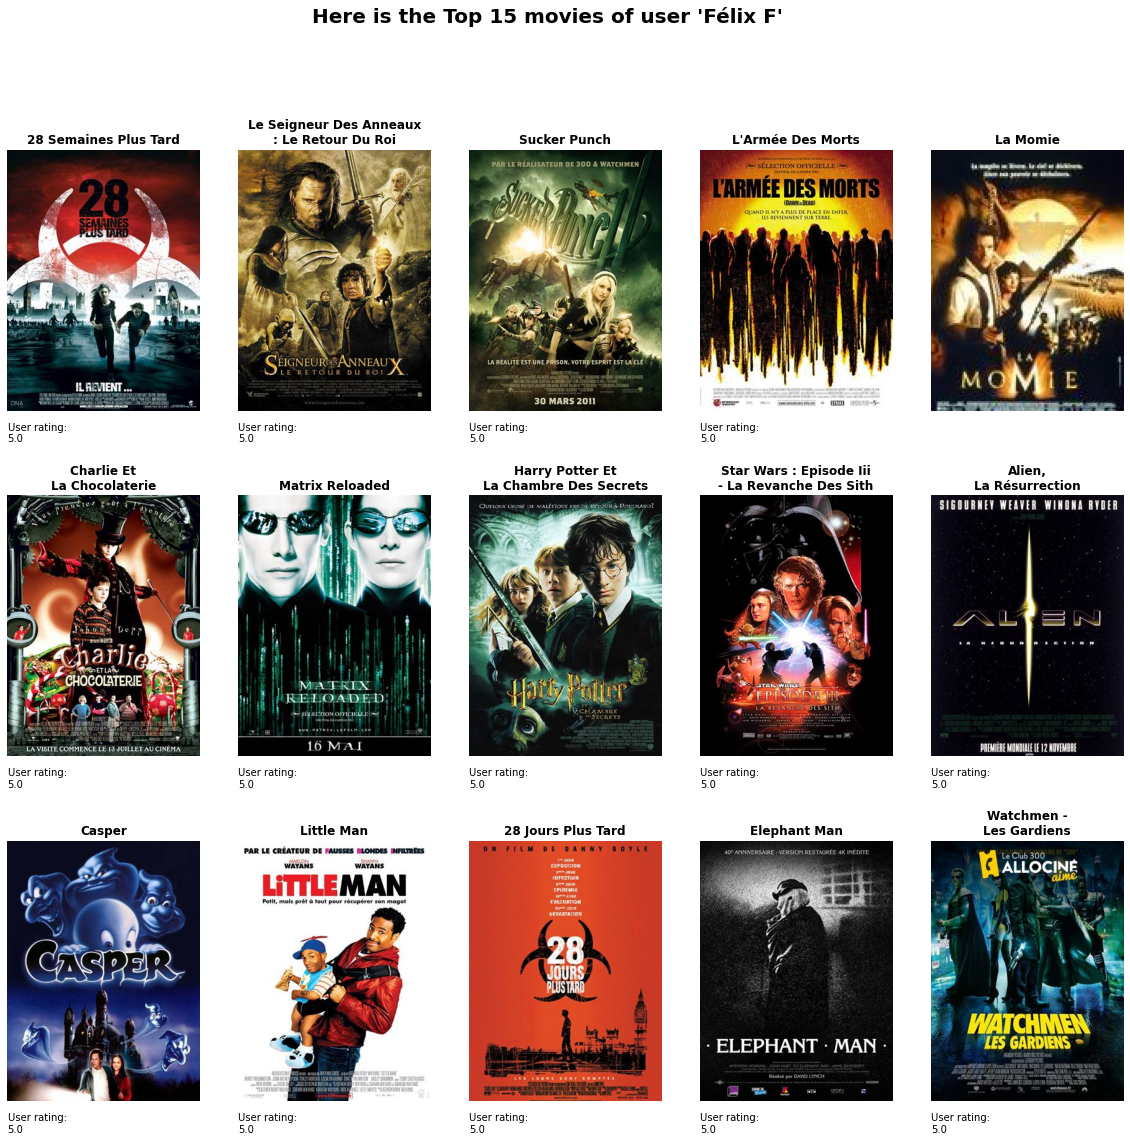

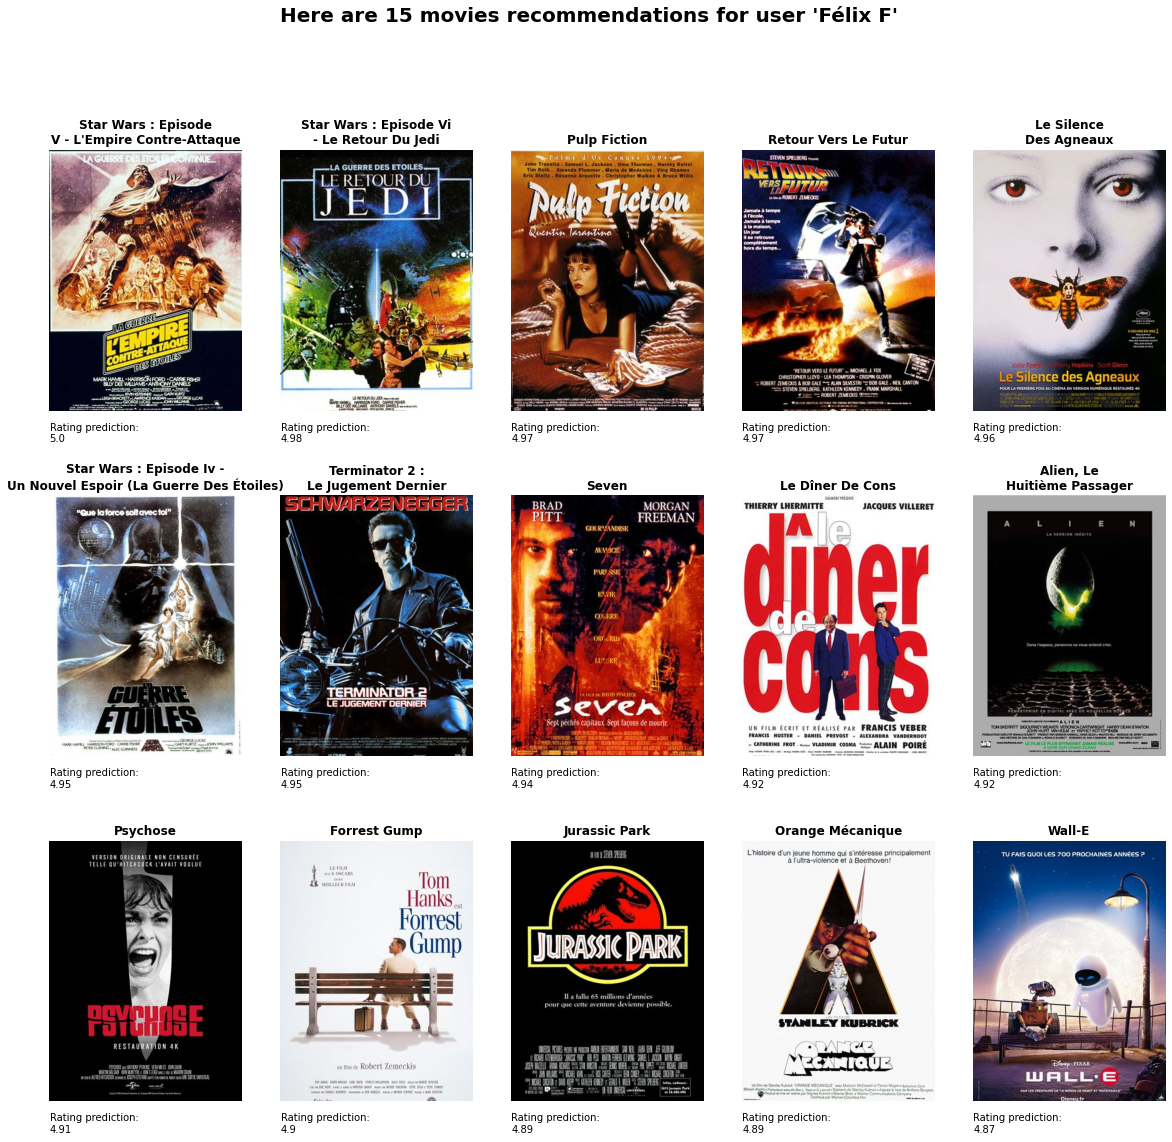

In [18]:
# MODEL N°1: CF_memory_based_recommendations (USER-BASED) (66, 67, 82, 91)
m_titles, m_ids = CF_memory_based_recommendations(user_prediction, norm_utility_matrix, user_movies_df=user_movies_df, 
                                                  drop_viewed_movies=False, top_movies=15, nb_recos=15)
display_recos(m_titles, m_ids, v_type="movies", reco_type="user-item")

In [ ]:
# MODEL N°2: CF_memory_based_recommendations (ITEM-BASED) (66, 82)
m_titles, m_ids = CF_memory_based_recommendations(item_prediction, norm_utility_matrix, user_movies_df=user_movies_df, 
                                                  drop_viewed_movies=False, top_movies=15, nb_recos=15)
display_recos(m_titles, m_ids, v_type="movies", reco_type="user-item")

#### Metrics

In [ ]:
def error_metrics(utility_matrix: pd.DataFrame, train_split_ratio: float, nb_iter: int, normalization_type: str):
    '''
    Compute the error metrics for the ratings predictions.
    :param utility_matrix: Matrix of users-items interactions with user ratings.
    :param train_split_ratio: Ratio of the train set size.
    :param nb_iter: Number of iterations to compute different values.
    :param normalization_type: Type of normalization to apply to the ratings.
    :return: Plot the error metrics.
    '''
    list_user_rmse, list_item_rmse, list_user_mae, list_item_mae = [], [], [], []
    train_matrix = utility_matrix.copy()
    for i in tqdm(range(nb_iter), desc=f"{normalization_type.title()} normalization - Ratings predictions error metrics"):
        # Save train_split_ratio of each user's interactions as a train set
        train_ratings = {index:row.loc[rd.sample(row.index[row !=0].tolist(), len(row.index[row !=0]))[:int(len(row.index[row !=0])*train_split_ratio)]] for index, row in train_matrix.iterrows()}
        norm_train_matrix = normalize_matrix(train_matrix, scaler=normalization_type)
        # Set all saved ratings to 0
        for u_id, ratings in train_ratings.items():
            norm_train_matrix.loc[u_id, ratings.index] = 0    
        # Compute the similarity matrix between users and items
        user_sim_train = 1-pairwise_distances(norm_train_matrix, metric='cosine')
        item_sim_train = 1-pairwise_distances(norm_train_matrix.T, metric='cosine')
        # Predict the ratings of the users in the train set and all others
        # and normalize the predictions in the same way as the ratings on [0,5]
        user_pred = predict_ratings(norm_train_matrix, user_sim_train, type='user')
        user_pred = ((normalize(user_pred,norm="max") + 1)/2 * 5)
        item_pred = predict_ratings(norm_train_matrix, item_sim_train, type='item').fillna(0)
        item_pred = ((normalize(item_pred,norm="max") + 1)/2 * 5)
        user_pred = pd.DataFrame(user_pred, index=norm_train_matrix.index, columns=norm_train_matrix.columns).round(1)
        item_pred = pd.DataFrame(item_pred, index=norm_train_matrix.index, columns=norm_train_matrix.columns).round(1)

        # Compute the RMSE of the predicted ratings
        # Compute MAE of the predicted ratings
        user_sum_sq_err, item_sum_sq_err = [], []
        user_mae, item_mae = [], []
        for u_id, ratings in train_ratings.items():
            user_sum_sq_err.append(((ratings - user_pred.loc[u_id, ratings.index])**2).sum()/len(ratings))
            item_sum_sq_err.append(((ratings - item_pred.loc[u_id, ratings.index])**2).sum()/len(ratings))
            user_mae.append((np.abs(ratings - user_pred.loc[u_id, ratings.index])).sum()/len(ratings))
            item_mae.append((np.abs(ratings - item_pred.loc[u_id, ratings.index])).sum()/len(ratings))

        user_rmse = np.sqrt(sum(user_sum_sq_err)/len(user_sum_sq_err)) 
        item_rmse = np.sqrt(sum(item_sum_sq_err)/len(item_sum_sq_err))
        user_mae = sum(user_mae)/len(user_mae)
        item_mae = sum(item_mae)/len(item_mae)
        list_user_rmse.append(user_rmse)
        list_item_rmse.append(item_rmse)
        list_user_mae.append(user_mae)
        list_item_mae.append(item_mae)
    
    # Plot the error metrics
    plt.figure(figsize=(15,8))
    plt.plot(list_user_rmse, "o-", label="User RMSE")
    plt.plot(list_item_rmse, "o-", label="Item RMSE")
    plt.plot(list_user_mae, "bo-", label="User MAE")
    plt.plot(list_item_mae, "ro-", label="Item MAE")
    plt.legend()
    plt.title(f"CF-Memory-based ratings prediction error metrics with \"{normalization_type.title()}\" normalization", fontsize=17, fontweight="bold")
    plt.xlabel("Iterations")
    plt.savefig(f"CF_memory_based_{normalization_type.title()}_error.png")
    plt.show()

In [ ]:
error_metrics(utility_matrix, train_split_ratio=0.2, nb_iter=20, normalization_type="standard")

In [ ]:
error_metrics(utility_matrix, train_split_ratio=0.2, nb_iter=20, normalization_type="l1")

In [ ]:
error_metrics(utility_matrix, train_split_ratio=0.2, nb_iter=20, normalization_type="l2")

In [ ]:
error_metrics(utility_matrix, train_split_ratio=0.2, nb_iter=20, normalization_type="min-max")

In [ ]:
error_metrics(utility_matrix, train_split_ratio=0.2, nb_iter=20, normalization_type="max")

## **Model CF N°2:** *Model-Based CF - Matrix factorization - SVD*

### **Define the sparse data variable for the model**

In [3]:
user_movie_ratings_mf = user_movies.groupby('user_id').filter(lambda x: len(x) >= 5)
user_movie_ratings_mf = user_movie_ratings_mf[["user_id", "movie_id", "user_rating"]]

# Generate the 'data' variable containing the rating data that will be used in the rating prediction algorithm
reader = Reader(rating_scale=(0.5, 5)) # mandatory parameter, defines the rating scale between 0.5 and 5.
data = Dataset.load_from_df(user_movie_ratings_mf, reader)

In [38]:
user_movie_ratings_mf.user_id.nunique()

2585

In [27]:
user_movie_ratings_mf.duplicated(subset=["user_id", "movie_id"]).sum()

0

In [39]:
user_movie_ratings_mf.movie_id.nunique()

7746

### **Launch the final model and get predictions**

In [28]:
# We split randomly the data from the DB: train and test sets (25% of the user movies ratings)
trainset, testset = train_test_split(data, test_size=.25)
# Use of SVD algorithm
algo_SVD = SVD(n_factors=200, n_epochs=50, lr_all=0.01, reg_all=0.1, biased=True, random_state=10)
# Training the model on trainset and predict the ratings of the testset.
algo_SVD.fit(trainset)
predictions = algo_SVD.test(testset)
# Then compute RMSE
print(f"RMSE: {accuracy.rmse(predictions)}")
print(f"MAE:  {accuracy.mae(predictions)}")

RMSE: 0.9321
RMSE: 0.932139450078641
MAE:  0.7285
MAE:  0.7285362447383793


In [29]:
print(trainset.n_items, trainset.n_users, trainset.n_ratings)

7716 2585 226518


In [12]:
print(trainset.n_items, trainset.n_users, trainset.n_ratings)

7719 2585 226518


In [48]:
missing_uid = [id for id in set(user_movie_ratings_mf.user_id.to_list()) if not trainset.knows_user(trainset.to_inner_uid(id))]

In [49]:
missing_uid

[]

In [25]:
len(testset) + 226518

302025

### **Get n best predictions for all users**

In [30]:
def get_top_n(predictions, n=10): 
    '''
    Return the top-N recommendation for each user from a set of predictions.
    :param predictions: object returned by the model's 'test' method. Contains the predictions.
    :param n: number of recommendation to output for each user.
    :return: dict where keys are user (raw) ids and values are lists of tuples: [(item, rating estimation), (item, rating estimation), ...]    
    '''
    # Calcul des prédictions pour chaque user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Tri des prédictions pour chaque user et sélection des n premiers
    for uid, user_ratings in top_n.items():
        list(user_ratings).sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [31]:
len(predictions)

75507

In [32]:
predictions

[Prediction(uid='Z20200307184114217262101', iid=130128, r_ui=5.0, est=2.0482114220980545, details={'was_impossible': False}),
 Prediction(uid='Z20050727171108940942246', iid=30411, r_ui=4.5, est=3.3259645992697884, details={'was_impossible': False}),
 Prediction(uid='Z20121022182542230468657', iid=238850, r_ui=2.5, est=3.407160727274609, details={'was_impossible': False}),
 Prediction(uid='Z20050523154208190799661', iid=257839, r_ui=3.5, est=3.8818088689793955, details={'was_impossible': False}),
 Prediction(uid='Z20071018170703807835161', iid=134066, r_ui=4.0, est=3.7795291770407706, details={'was_impossible': False}),
 Prediction(uid='Z20110302224523870332136', iid=9257, r_ui=3.5, est=3.3410693191412997, details={'was_impossible': False}),
 Prediction(uid='Z20040827093310567684711', iid=229905, r_ui=2.0, est=3.0535324803393955, details={'was_impossible': False}),
 Prediction(uid='Z20030227084758843717727', iid=608, r_ui=5.0, est=3.001000449484632, details={'was_impossible': False}),


In [33]:
predictions
p_uid=[uid for uid, iid, true_r, est, _ in predictions]

In [45]:
missing_uid = [id for id in set(user_movie_ratings_mf.user_id.to_list()) if id not in set(p_uid)]
missing_uid

['Z20060907170646343769884',
 'Z20141023150058747128895',
 'Z20120131221008017315762',
 'Z20090811141736853878459',
 'Z20210126111443843024387',
 'Z20100427120918077133249',
 'Z20071221160050687707274',
 'Z20161119061839833111782',
 'Z20180317195303453834433',
 'Z20170515225834123349132',
 'Z20020118173047950342896',
 'Z20010731172833573189492',
 'Z20100817234154833874963',
 'Z20141003185913440214955',
 'Z20100308153517313532114',
 'Z20070723171355157511878',
 'Z20210927215808851819133',
 'Z20111202160813693244965',
 'Z20150530172103410947142',
 'Z20160611211933467127326',
 'Z20050713140035720148761',
 'Z20211031084735112911167',
 'Z20111231010756097519287',
 'Z20090617201359150608418',
 'Z20090730002920367508158',
 'Z20070215004936890248245',
 'Z20050401165739600395199',
 'Z20070128085918873318331',
 'Z20170724221005970153293',
 'Z20061209185248320186224',
 'Z20100206191715887644955',
 'Z20101014102833760655731',
 'Z20141012174307457392383',
 'Z20130709211751227195184',
 'Z20080713205

In [46]:
len(missing_uid)

199

In [35]:
len(p_uid) - len(set(p_uid))

73121

In [36]:
top_n = get_top_n(predictions, n=15)
# Print des items recommandés pour chaque user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Z20200307184114217262101 [130128, 202971, 29716, 33300, 184653, 27417, 8230, 268348, 1945, 111823, 246, 239210, 230453, 126155, 10905]
Z20050727171108940942246 [30411, 24712, 239210, 14604, 254955, 1841, 109000, 124554, 798, 44185, 196560, 204, 254758, 266327, 230727]
Z20121022182542230468657 [238850, 229870, 199842, 237561, 127658, 194397, 15817, 44792, 244062, 269758, 38822, 256559, 244978, 197041, 50356]
Z20050523154208190799661 [257839, 59831, 229969, 2577, 138826, 55413, 101104, 109551, 228021, 109192, 264918, 148102, 218761, 135549, 137350]
Z20071018170703807835161 [134066, 25636, 145721, 197047, 108986, 57826, 1538, 131948, 126372, 46941, 145471, 129766, 130593, 22037, 57851]
Z20110302224523870332136 [9257, 224799, 203691, 6122, 10257, 218237, 227551, 240082, 32599, 1170, 13211, 181593, 185293, 16220, 134003]
Z20040827093310567684711 [229905, 215769, 60981, 255238, 88396, 251354, 34003, 4312, 170958, 27405, 181022, 4413, 26282, 2604, 195120]
Z20030227084758843717727 [608, 22696,

In [50]:
u_idx=-1
while u_idx < 0 or u_idx >= len(top_n):
        u_idx = int(input(f"Enter the number of the user you want to get recommendations for (between 1 and {len(top_n)}): ")) - 1
user_id = list(top_n.keys())[u_idx]
CF_SVD_recos = top_n[user_id]
CF_SVD_recos

[(261274, 2.5338645318693853)]

### **Estimation of the best parameters and performance**

In [ ]:
# SVD ET CROSS VALIDATION
# Use of SVD algorithm
algo_SVD_cv = SVD(n_factors=200, n_epochs=100, lr_all=0.01, reg_all=0.1, biased=True, random_state=0)
# Cross validation with k=5 folds and RMSE and MAE metrics
cross_validate(algo_SVD_cv, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [9]:
# Use of GridSearch to find the best parameters for the SVD model
lr_all = [0.1, 0.01, 0.005]
reg_all = [0.2, 0.5, 1]
n_epochs = [20, 30]
n_factors=[100, 200]
param_grid = {'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-3)
gs.fit(data)
# Best RMSE obtained with the proposed parameters
print(f"RMSE: {gs.best_score['rmse']}")
# Parameters that lead to the best RMSE
print(gs.best_params['rmse'])
# Best MAE obtained with the proposed parameters
print(f"MAE: {gs.best_score['mae']}")
# Parameters that lead to the best MAE
print(gs.best_params['mae'])

RMSE: 0.9502719237004852
{'n_factors': 200, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}
MAE: 0.7475297055903726
{'n_factors': 200, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [10]:
# Use of GridSearch to find the best parameters for the SVD model
lr_all = [0.1, 0.01, 0.05]
reg_all = [0.2, 0.01, 0.1]
n_epochs = [30, 40]
n_factors=[200, 300]
param_grid = {'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-3)
gs.fit(data)
# Best RMSE obtained with the proposed parameters
print(f"RMSE: {gs.best_score['rmse']}")
# Parameters that lead to the best RMSE
print(gs.best_params['rmse'])
# Best MAE obtained with the proposed parameters
print(f"MAE: {gs.best_score['mae']}")
# Parameters that lead to the best MAE
print(gs.best_params['mae'])

RMSE: 0.9317204132018848
{'n_factors': 200, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}
MAE: 0.7274959970718431
{'n_factors': 200, 'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


In [11]:
# Use of GridSearch to find the best parameters for the SVD model
lr_all = [0.008, 0.01]
reg_all = [0.4, 0.05, 0.1]
n_epochs = [40, 50]
n_factors=[200]
param_grid = {'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-3)
gs.fit(data)
# Best RMSE obtained with the proposed parameters
print(f"RMSE: {gs.best_score['rmse']}")
# Parameters that lead to the best RMSE
print(gs.best_params['rmse'])
# Best MAE obtained with the proposed parameters
print(f"MAE: {gs.best_score['mae']}")
# Parameters that lead to the best MAE
print(gs.best_params['mae'])

RMSE: 0.9316985292738114
{'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}
MAE: 0.7267720608069304
{'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [12]:
# Use of GridSearch to find the best parameters for the SVD model
lr_all = [0.01]
reg_all = [0.1]
n_epochs = [50, 100]
n_factors=[200]
param_grid = {'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-3)
gs.fit(data)
# Best RMSE obtained with the proposed parameters
print(f"RMSE: {gs.best_score['rmse']}")
# Parameters that lead to the best RMSE
print(gs.best_params['rmse'])
# Best MAE obtained with the proposed parameters
print(f"MAE: {gs.best_score['mae']}")
# Parameters that lead to the best MAE
print(gs.best_params['mae'])

RMSE: 0.9310603450739912
{'n_factors': 200, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}
MAE: 0.72703642477365
{'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [56]:
# Retrieve the trainset.
trainset = data.build_full_trainset()
# Build an algorithm, and train it.
algo_KNN = KNNBasic()
algo_KNN.fit(trainset)
uid = "Z20200307184114217262101" # raw user id (as in the ratings file)
iid = 228087 # raw item id (as in the ratings file)
# get a prediction for specific users and items.
pred = algo_KNN.predict(uid, iid, r_ui=5, verbose=True)
pred

Computing the msd similarity matrix...
Done computing similarity matrix.
user: Z20200307184114217262101 item: 228087     r_ui = 5.00   est = 3.01   {'actual_k': 40, 'was_impossible': False}


Prediction(uid='Z20200307184114217262101', iid=228087, r_ui=5, est=3.0143438120992916, details={'actual_k': 40, 'was_impossible': False})